In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from bench_isolation_forest_parallel_predict import test_n_rows, test_n_trees

In [2]:
def plot_speed_up(speed_up_values, x_label, y_label, legend_base):
    ax = sns.heatmap(speed_up_values)
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.show()
    
    for i in range(speed_up_values.shape[0]):
        label_name = "{}={}".format(legend_base, speed_up_values.index.tolist()[i])
        plt.plot(np.arange(0, speed_up_values.shape[1]), 
                 speed_up_values.values[i, :], 
                 label=label_name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(0, speed_up_values.shape[1]), 
               speed_up_values.columns.tolist())
    plt.legend()
    plt.show()

# Benchmark

In this notebook we are benchmarking parallelizing Isolation Forest during prediction time. At the moment, prediction runs single-threaded.

We added parallelization at the trees level, i.e., each tree is run in a parallel thread. We will evaluate its impact on runtime in two scenarios:
- Fix the number of trees, and vary the amount of data and number of parallel threads.
- Fix the amount of data, and vary the number of trees and number of parallel threads.

**Methodology**
- The used data is randomly generated. The seed is fixed in each test, so we obtain reproducible results.
- We first obtain the runtimes from the current Isolation Forest implementation ($t_s$). For this test, we also vary the number of parallel threads (although it runs single-threaded during prediction, we ran it anyway to get the baseline runtimes).
- Then, we vary the variables under study and obtain the running times ($t_p$). Finally, we obtain the speed up values as $\frac{t_s}{t_p}$. Speed up > 1 means that the parallel method was faster than the single threaded one. Values in ]0, 1] means that the parallel method was slower or similar with the single threaded one.
- Check the companion bench_isolation_forest_parallel_predict.py for code.

### Scenario 1 - evaluate performance with the amount of data

In this test, we fixed the number of trees to 100, and we varied the amount of data in an exponential increasing fashion. We evaluate the run times and speed up obtained by increasing the number of parallel threads.

1) The first table shows the runtimes of the current implementation, which is single-threaded during prediction. We can see that run times are quite similar as we increase the number of parallel threads for the same amount of data. Obviously, the runtime increases with the amount of prediction data.

2) The second table shows the runtimes with the Isolation Forest in the PR with parallel threads during prediction.

3) The third table shows the obtained speed ups. We can see that for really small amounts of data (1000 samples) the parallel approach is slower. This is kind of expected, as managing the parallel jobs and fusing the results have some overhead. However, when we increase the amount of test data (>= 10000 samples) we already obtain some speed ups. From the line plots, it is possible to see the speed ups. For 10,000 samples, we can see that it reaches a maximum speed up at 6 threads, after which it slows down due to the overhead of increasing the number of parallel jobs.

**Note:** in the heat map plot, the label of the y axis should be read as n_samples, and the colorbar represents the speed up.

	Current prediction execution time:


,1,2,4,6,8,10,12
1000,0.069413,0.077515,0.077682,0.078966,0.075987,0.078891,0.079414
10000,0.473504,0.418893,0.454697,0.427628,0.427280,0.435462,0.432534
100000,4.952560,5.065967,5.092305,5.046283,5.142919,5.209041,5.087838
1000000,71.440234,71.948269,71.895934,73.822388,73.260454,75.659868,74.553673


	Pull request prediction execution time:


,1,2,4,6,8,10,12
1000,0.071313,0.105331,0.125889,0.126074,0.124422,0.126365,0.125713
10000,0.486538,0.315111,0.311780,0.212974,0.273525,0.272289,0.314209
100000,4.983544,3.525932,2.474958,2.221793,2.138582,2.134388,2.099686
1000000,71.327752,42.613682,27.164012,22.282474,20.823076,20.287536,19.951281


	Speed up:


,1,2,4,6,8,10,12
1000,0.973358,0.735921,0.617065,0.626343,0.610718,0.624311,0.631711
10000,0.973210,1.329351,1.458391,2.007891,1.562123,1.599262,1.376580
100000,0.993783,1.436774,2.057532,2.271266,2.404826,2.440531,2.423142
1000000,1.001577,1.688384,2.646735,3.313025,3.518234,3.729377,3.736786


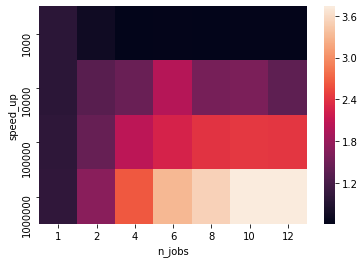

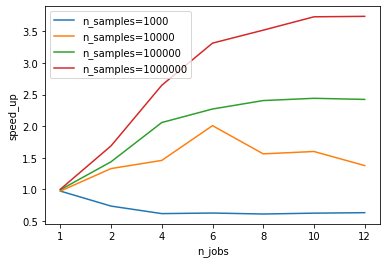

CPU times: user 4h 11min 21s, sys: 1h 36min 14s, total: 5h 47min 36s
Wall time: 2h 3min 57s


In [3]:
%%time

n_samples_list = [1000, 10000, 100000, 1000000]
n_jobs_list = [1, 2, 4, 6, 8, 10, 12]
n_features = 30
repetitions = 5
n_trees = 100

results_sklearn_iforest_n_samples, results_parallel_iforest_n_samples, speed_up_n_samples = \
    test_n_rows(n_samples_list=n_samples_list, n_jobs_list=n_jobs_list, 
                n_features=n_features, repetitions=repetitions,
                n_trees=n_trees)

print("\tCurrent prediction execution time:")
display(results_sklearn_iforest_n_samples)
print("\tPull request prediction execution time:")
display(results_parallel_iforest_n_samples)
print("\tSpeed up:")
display(speed_up_n_samples)

plot_speed_up(speed_up_n_samples, x_label="n_jobs", y_label="speed_up",
              legend_base="n_samples")

### Scenario 2 - evaluate performance with the number of trees

In this test, we fixed the number of samples to 10000, and we varied the number of trees in an increasing fashion. We evaluate the run times and speed up obtained by increasing the number of parallel threads.

1) The first table shows the runtimes of the current implementation, which is single-threaded during prediction. We can see that run times are quite similar as we increase the number of parallel threads for the same number of trees. Of course, the runtime increases with the number of trees.

2) The second table shows the runtimes with the Isolation Forest in the PR with parallel threads during prediction.

3) The third table shows the obtained speed ups. We can see improvements even the smallest number of trees (50). Still, we obtained better runtime improvements as we increase the number of trees. From the line plots, it appears that if we keep increasing the number of trees, we will obtain smaller, but improved runtime speed ups as compared with single-threaded predictions.

**Note:** in the heat map plot, the label of the y axis should be read as n_jobs, and the colorbar represents the speed up.

	Current prediction execution time:


,1,2,4,6,8,10,12
50,2.726790,2.744643,2.706976,2.766137,2.695822,2.727410,2.677205
100,5.414576,5.214951,5.360220,5.332366,5.436479,5.453385,5.330459
150,7.823806,7.925228,7.879474,8.139251,8.072107,8.153150,8.321236
200,10.649652,10.491630,10.543509,10.669667,10.742657,10.902812,10.802477
250,13.455915,13.070973,13.454749,13.764625,13.550098,13.379263,13.740879
300,15.723188,15.909311,15.927997,16.441416,16.505590,16.220870,17.125871


	Pull request prediction execution time:


,1,2,4,6,8,10,12
50,2.748218,1.903008,1.365174,1.203547,1.167573,1.163099,1.116704
100,5.305699,3.592879,2.505987,2.260282,2.186612,2.127984,2.144225
150,7.858588,5.396187,3.707729,3.289554,3.215121,3.160396,3.217827
200,10.641617,7.115108,4.920427,4.364433,4.208351,4.179718,4.149741
250,13.717914,8.844054,6.127013,5.434702,5.288669,5.228249,5.181533
300,15.940887,10.729003,7.340624,6.425016,6.289404,6.204439,6.313665


	Speed up:


,1,2,4,6,8,10,12
50,0.992203,1.442266,1.982881,2.298321,2.308912,2.344951,2.397417
100,1.020521,1.451469,2.138966,2.359160,2.486257,2.562700,2.485960
150,0.995574,1.468672,2.125148,2.474272,2.510670,2.579787,2.585980
200,1.000755,1.474557,2.142804,2.444686,2.552700,2.608504,2.603169
250,0.980901,1.477939,2.195972,2.532729,2.562100,2.559033,2.651895
300,0.986343,1.482832,2.169842,2.558969,2.624349,2.614397,2.712508


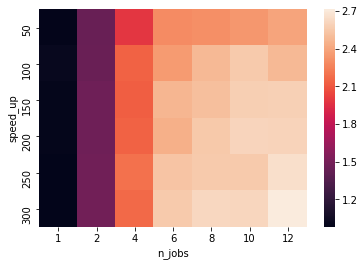

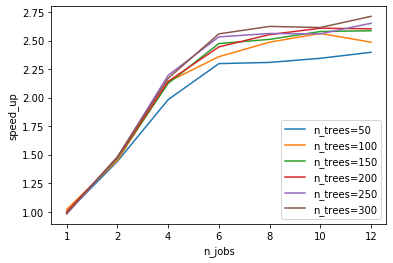

CPU times: user 3h 50min 19s, sys: 34min 20s, total: 4h 24min 40s
Wall time: 1h 39min 28s


In [4]:
%%time

n_trees_list = [50, 100, 150, 200, 250, 300]
n_jobs_list = [1, 2, 4, 6, 8, 10, 12]
n_features = 30
repetitions = 5
n_samples = 100000

results_sklearn_iforest_n_trees, results_parallel_iforest_n_trees, speed_up_n_trees = \
    test_n_trees(n_trees_list=n_trees_list, n_jobs_list=n_jobs_list, 
                 n_features=n_features, repetitions=repetitions,
                 n_samples=n_samples)

print("\tCurrent prediction execution time:")
display(results_sklearn_iforest_n_trees)
print("\tPull request prediction execution time:")
display(results_parallel_iforest_n_trees)
print("\tSpeed up:")
display(speed_up_n_trees)

plot_speed_up(speed_up_n_trees, x_label="n_jobs", y_label="speed_up",
              legend_base="n_trees")

#### Final remarks 

The results in this benchmark show that Isolation Forest's prediction runtime benefits from doing it with parallel threads. If the amount of data is very small, it is slower, which is expected, as there is some overhead.

We evaluated the effect of increasing the amount of test data and number of trees separately. However, we could expect to obtain even higher speed ups if we increase both the amount of data and the number of parallel threads. This is actually what we got with our private data.

When the amount of data is small (1000 samples), running prediction in parallel is slower than in parallel. However, the runtimes of the parallel method was < 120 ms, which is still relatively fast. To conclude, parallel prediction can bring benefits when we have > 1000 points and improves with the number of trees. This is important in applications with more data at prediction time, but also during hyper-parameter search, when we need to run several trials.